#####For Neural Network Layer dimension, pls refer:
https://docs.google.com/document/d/15bQU7XRonOu9Pn1nDtkJVp2CruWG09jOQaRUEOoUs4I/edit?usp=sharing

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
import torch
import torchvision
from torchvision.transforms import transforms

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

In [ ]:
#trainset = torchvision.datasets.CIFAR10(root='/content/cifar', train=True, download=True, transform=transform)

Extracting /content/cifar/cifar-10-python.tar.gz to /content/cifar


In [ ]:
#The file is already in google drive, pls don't download again.
trainset = torchvision.datasets.CIFAR10(root="/content/drive/My Drive/app", train=True, download=False, transform=transform)

In [ ]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)

In [ ]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [ ]:
bat1_dict = unpickle('/content/cifar/cifar-10-batches-py/data_batch_1')

In [ ]:
testset = torchvision.datasets.CIFAR10(root = "/content/cifar", train = False, download = True, transform=transform)

Files already downloaded and verified


In [ ]:
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False)

In [ ]:
classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

In [ ]:
import matplotlib.pyplot as plt
def convert_to_imshow_format(image):
  image = image/2 + 0.5
  image = image.numpy()
  return image.transpose(1,2,0)


In [ ]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

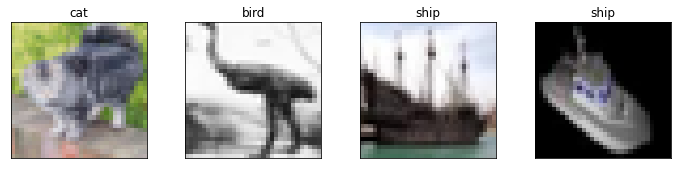

In [ ]:
fig, axes = plt.subplots(1, len(images), figsize = (12,2.5))
for idx, image in enumerate(images):
  axes[idx].imshow(convert_to_imshow_format(image))
  axes[idx].set_title(classes[labels[idx]])
  axes[idx].set_xticks([])
  axes[idx].set_yticks([])

#####Input > Conv (ReLU) > MaxPool > Conv (ReLU) > MaxPool > FC (ReLU) > FC (ReLU) > FC (SoftMax) > 10 outputs

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()  #Input is 3*32*32
    self.Conv1 = nn.Conv2d(3,6,5) #1st Conv: 3 channels, 6 filters, 5*5 kernel, o/p:(32-5)+1=28
    self.pool = nn.MaxPool2d(2,2)#1st pool: 2*2, o/p:6*14*14
    self.Conv2 = nn.Conv2d(6,16,5)#2nd Conv: 6 channels, 16 filter, 5*5 kernel, o/p:(14-5)+1=10
    self.pool = nn.MaxPool2d(2*2)#2nd pool: 2*2, o/p:16*5*5
    self.fc1 = nn.Linear(16 * 5 * 5, 120)#ReLU activation & needs 120 nodes.((16*5*5)+1)*120, Visit torch.tensor.view
    self.fc2 = nn.Linear(120, 84)#ReLU activation & needs 84 nodes, 120 from previous line
    self.fc3 = nn.Linear(84, 10)#Softmax activation & needs 10 nodes for 10 classes of CIFAR10 labels

  def Forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16 * 5 * 5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

net = Net()

######Defining the loss function to Cross-entropy as it is multi class classification. Optimization will be stochastic gradient descent(SGD)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net()

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
import os

model_directory_path = "/content/drive/My Drive/app"
model_path = model_directory_path + "cifar-10-cnn-model.pt"

if not os.path.exists(model_directory_path):
  os.makedirs(model_directory_path)
if os.path.isfile(model_directory_path):
  net.load_state_dict(torch.load(model_path))#Load trained parameters from disk if model is present else run model#
  print("Loaded model parameters from disk")
else:
  for epoch in range(2):#Loop on dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader,0):
      inputs, labels = data#Get inputs

      optimizer.zero_grad()#Zero parameter gradients
      
      outputs = net(inputs)#forward+backward+optimize
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      if i % 2000 == 1999:
        print("[%d, %5d]) loss: %.3f"%
              (epoch +1, i+1, running_loss/2000))
        running_loss = 0.0
    print("Finished training")
    torch.save(net.state_dict(), model_path)#Saving the model to model_path(path defined in the beginning)
    print("Save model parameters to disk")


[1,  2000]) loss: 2.165
[1,  4000]) loss: 1.849
[1,  6000]) loss: 1.689
[1,  8000]) loss: 1.595
[1, 10000]) loss: 1.564
[1, 12000]) loss: 1.506
Finished training
Save model parameters to disk
[2,  2000]) loss: 1.433
[2,  4000]) loss: 1.406
[2,  6000]) loss: 1.419
[2,  8000]) loss: 1.367
[2, 10000]) loss: 1.326
[2, 12000]) loss: 1.320
Finished training
Save model parameters to disk


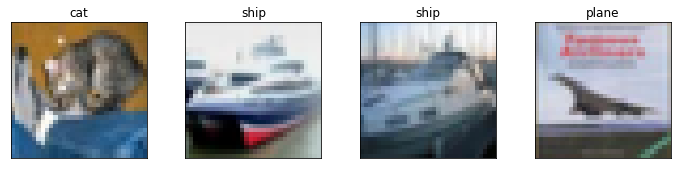

In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

fig, axes = plt.subplots(1, len(images), figsize=(12, 2.5))
for idx, image in enumerate(images):
  axes[idx].imshow(convert_to_imshow_format(image))
  axes[idx].set_title(classes[labels[idx]])
  axes[idx].set_xticks([])
  axes[idx].set_yticks([])

In [ ]:
outputs = net(images)
outputs

("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

tensor([[-1.3797, -3.4482,  1.4272,  4.3514,  0.6656,  2.7949,  2.9661, -2.2010,
         -1.7980, -3.0914],
        [ 4.5347, 10.0481, -2.4995, -3.6417, -5.3645, -5.6254, -5.3158, -5.3752,
          5.5999,  5.8172],
        [ 1.4669,  4.0127, -0.9596, -1.2606, -2.2512, -2.2867, -1.8446, -3.1248,
          3.2539,  2.1375],
        [ 3.5700,  1.8924, -0.4290, -1.8911, -0.7565, -2.8035, -3.2087, -1.6331,
          3.4874,  1.5291]], grad_fn=<AddmmBackward>)

In [ ]:
#If we want probaility score, nn.Softmax can be used
sm = nn.Softmax(dim=1)
sm_outputs = sm(outputs)
print(sm_outputs)

tensor([[2.0958e-03, 2.6486e-04, 3.4704e-02, 6.4612e-01, 1.6203e-02, 1.3625e-01,
         1.6169e-01, 9.2183e-04, 1.3794e-03, 3.7840e-04],
        [3.9137e-03, 9.7061e-01, 3.4490e-06, 1.1007e-06, 1.9653e-07, 1.5140e-07,
         2.0635e-07, 1.9444e-07, 1.1355e-02, 1.4111e-02],
        [4.5603e-02, 5.8159e-01, 4.0289e-03, 2.9815e-03, 1.1072e-03, 1.0686e-03,
         1.6627e-03, 4.6221e-04, 2.7232e-01, 8.9176e-02],
        [4.3831e-01, 8.1882e-02, 8.0359e-03, 1.8623e-03, 5.7914e-03, 7.4785e-04,
         4.9867e-04, 2.4104e-03, 4.0353e-01, 5.6937e-02]],
       grad_fn=<SoftmaxBackward>)


In [ ]:
#Predicted category for 4 test images
probs, index = torch.max(sm_outputs, dim=1)

for p, i in zip(probs, index):
  print("{0} - {1:.4f}".format(classes[i],p))

cat - 0.6461
car - 0.9706
car - 0.5816
plane - 0.4383
